<a href="https://colab.research.google.com/github/google/making_with_ml/blob/master/sports_ai/Sports_AI_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing My Tennis Serve with Machine Learning

In this notebook, you will use the Video Intelligence API to analyze a tennis serve, including the angle of the arms and legs during the serve. 

You will also build a custom model to track the speed of a tennis ball after being served.

## Setup

First, install the necessary libraries. The first cell will download and install the libraries onto the notebook, and the next cell imports them.

In [ ]:
!pip install google-cloud-automl

You might have to restart your runtime to load these packages.

In [ ]:
import sys
import os
import json
import math

import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np

from google.cloud import automl
from google.cloud import videointelligence_v1p3beta1 as videointelligence
from google.oauth2 import service_account

Fill in your info below by specifying your project id. You'll also need to choose a bucket name (that should start with `gs://`). You can use your Qwiklabs ID as both your "project_id" and your "bucket" as it's always a unique name.

In [ ]:
# TODO: REMOVE MY SPECIFIC CONFIG
project_id = 'qwiklabs-gcp-01-248499b468e1'  #@param {type: "string"}
bucket = 'gs://qwiklabs-gcp-01-248499b468e1' #@param {type: "string"}

Next, create your bucket, enable the video intelligence and automl APIs, and generate a service account key to access the AutoML API. For this lab, you will use your autogenerated Qwiklabs Service Account.

In [ ]:
!gcloud config set project {project_id}
!gsutil mb {bucket}
!gcloud iam service-accounts keys create ./key.json --iam-account {project_id}@{project_id}.iam.gserviceaccount.com

# Enable the Video Intelligence API and AutoML
!gcloud services enable videointelligence.googleapis.com
!gcloud services enable automl.googleapis.com

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./key.json"

## Using the Video Intelligence API

In this bit, you will analyze a skeleton using the Video Intelligence API. The API tracks all sorts of features, including features of the face, but, for this lab, you will only focus on the body:

![alt text](https://github.com/google/making_with_ml/blob/master/sports_ai/assets/posture_tracking.gif?raw=true))

To do this, you will use a prerecorded video of multiple tennis serves. It's important to note that the same methods used in this lab could be used to analyze other types of actions like a kick in soccer or a swing in baseball.

In [ ]:
input_uri = "gs://spls/aiforsports/tennis_serves.mp4"
output_uri = os.path.join(bucket, 'output.json')

Now, run the Video Intelligence API's Person Detection feature on the video from the bucket. You pass this function the input path to the file in cloud storage as well as an output path where you want the results to be written. 

In [ ]:
# This function comes from the docs
# https://cloud.google.com/video-intelligence/docs/people-detection
def detect_person(input_uri, output_uri):
    """Detects people in a video."""

    client = videointelligence.VideoIntelligenceServiceClient(credentials=service_account.Credentials.from_service_account_file(
    './key.json'))

    # Configure the request
    config = videointelligence.types.PersonDetectionConfig(
        include_bounding_boxes=True,
        include_attributes=True,
        include_pose_landmarks=True,
    )
    context = videointelligence.types.VideoContext(person_detection_config=config)

    # Start the asynchronous request
    operation = client.annotate_video(
        input_uri=input_uri,
        output_uri=output_uri,
        features=[videointelligence.enums.Feature.PERSON_DETECTION],
        video_context=context,
    )

    return operation


In [ ]:
# If you get a permissions episode here, you might have to modify the permissions
# on your bucket to allow your service account to access it. Do that in the 
# GCP storage console/UI.
operation = detect_person(input_uri, output_uri)

`detect_person` is an asynchronous function and it will take a minute or two for the entire video to be analyzed. You can check the status of the analysis by calling `operation.done`:

In [ ]:
print(f"Operation ${operation.operation.name} is done? {operation.done()}")

Note that even if you restart this notebook, the Video Intelligence API will still be analyzing your video in the cloud! So you won't lose any progress.

Once the operation is finished, download the results from your cloud storage bucket:

In [ ]:
# Note! This won't work unless operation.done() == True!
!mkdir tmp
!gsutil cp {output_uri} tmp

## Formatting the Data

Results are written to cloud storage as a json file. Run this command to load them:

In [ ]:
data = json.load(open('./tmp/output.json'))

These json files are usually pretty big, so don't print them! Instead, inspect the structure:

In [ ]:
print(data.keys())
# You only care about annotation_results[0] because you only have one video
print(len(data['annotation_results'][0]['person_detection_annotations']))

It's easy to get lost in all these nested fields, but the important data for this lab is stored in `data['annotation_results`][0][`person_detection_annotations`]. Store it in `people_annotations`:

In [ ]:
people_annotations = data['annotation_results'][0]['person_detection_annotations']

In `people_annotations`, every entry corresponds to a person and each person has a unique set of `tracks`, or tracked segments. Write a helper function to parse through the data and rearrange it to make it easier to use:

In [ ]:
'''
This helper function takes in a person and rearranges the data so it's in 
a timeline, which will make it easier for us to work with
'''
def analyzePerson(person):
  frames = []
  for track in person['tracks']:
    # Convert timestamps to seconds
    for ts_obj in track['timestamped_objects']:
      time_offset = ts_obj['time_offset']
      timestamp = 0
      if 'nanos' in time_offset:
        timestamp += time_offset['nanos'] / 10**9
      if 'seconds' in time_offset:
        timestamp += time_offset['seconds']
      if 'minutes' in time_offset:
        timestamp += time_offset['minutes'] * 60
      frame= {'timestamp' : timestamp}
      for landmark in ts_obj['landmarks']:
        frame[landmark['name'] + '_x'] = landmark['point']['x']
        # Subtract y value from 1 because positions are calculated
        # from the top left corner
        frame[landmark['name'] + '_y'] = 1 - landmark['point']['y']
      frames.append(frame)
  sorted(frames, key=lambda x: x['timestamp'])
  return frames

Next, store the data in a pandas DataFrame (also for convenience), and sort each data point by timestamp:

In [ ]:
annotationsPd = pd.DataFrame(analyzePerson(people_annotations[0]))
for annotation in people_annotations[1:]:
  annotationsPd = annotationsPd.append(pd.DataFrame(analyzePerson(annotation)))

annotationsPd = annotationsPd.sort_values('timestamp', ascending=True)

Now, take a look at the results!

In [ ]:
annotationsPd.head()

As you can see above, the data is organized by the position of each body part by timestamp. Note that this works because there is only one person in the video used for this lab.

## Plotting the Data

With the video data formatted, plot the positions of the wrists and try to determine the start and end time of a serve:

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['left_wrist_y', 'right_wrist_y'], figsize=(20, 5))
plt.title("Left and Right Wrist Positions Over Time")
plt.savefig("wrist_pos")

From the plot above, you can actually identify the time of a serve pretty easily! First, the tennis ball is thrown up with the left hand (peak in left wrist). Then, a few seconds later, the ball is hit with the racket (peak in right wrist y).

The above plot is useful, but what would be even better would be understanding the angles of the elbow, knee, etc. 

## Computing Angles
Step 1: create some classes for making working with points easier:

In [ ]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y 

To compute the angle made by three points, we use the [Law of Cosines](https://www.google.com/search?q=rule+of+cosines&oq=rule+of+cosines&aqs=chrome.0.0l8.1048j1j7&sourceid=chrome&ie=UTF-8#wptab=s:H4sIAAAAAAAAAONgVuLQz9U3SMkuLnjE6Mgt8PLHPWEpi0lrTl5jNOLiCs7IL3fNK8ksqRRS4WKDsqS4eKTgmjQYpLi44DyeXUyCzvl5yakFJc6JOcmlOYkl-UWLWCV9EssV8tMUkvOLM_NSixWS4XIALyw914AAAAA). Imagine a triangle with side lengths a, b, and c. Then, to find 𝛾 (the angle across from side c), the formula is:

\begin{equation*}
\gamma = \cos^{-1}\frac{a^2+b^2 - c^2}{2ab}
\end{equation*}

The math is provided for you in this lab, but if it feels a bit confusing, there's a good explanation and code sample [here](https://medium.com/@manivannan_data/find-the-angle-between-three-points-from-2d-using-python-348c513e2cd), from which this function is borrowed:

In [ ]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c.y-b.y, c.x-b.x) - math.atan2(a.y-b.y, a.x-b.x))
    return ang

Using the `point` class and `getAngle` method, compute some useful angles below:

In [ ]:
def computeElbowAngle(row, which='right'):
  wrist = Point(row[f'{which}_wrist_x'], row[f'{which}_wrist_y'])
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  return getAngle(wrist, elbow, shoulder)

def computeShoulderAngle(row, which='right'):
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  return getAngle(hip, shoulder, elbow)

def computeKneeAngle(row, which='right'):
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  knee = Point(row[f'{which}_knee_x'], row[f'{which}_knee_y'])
  ankle = Point(row[f'{which}_ankle_x'], row[f'{which}_ankle_y'])
  return getAngle(ankle, knee, hip)

In [ ]:
# For a single timeslot...
row = annotationsPd.iloc[-1]
print("Elbow angle: " + str(computeElbowAngle(row)))
print("Shoulder angle: " + str(computeShoulderAngle(row)))
print("Knee angle: " + str(computeKneeAngle(row)))

Now, plot those angles over time.

In [ ]:
annotationsPd['right_elbow_angle'] = annotationsPd.apply(computeElbowAngle, axis=1)
annotationsPd['right_shoulder_angle'] = annotationsPd.apply(computeShoulderAngle, axis=1)
annotationsPd['right_knee_angle'] = annotationsPd.apply(computeKneeAngle, axis=1)

Next, plot the results!

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), color='blue')
plt.title("Right Elbow Angle over Time")
plt.savefig("right_elbow_angle")
annotationsPd.plot('timestamp', ['right_shoulder_angle'], figsize=(20, 5), color='purple')
plt.title("Right Shoulder Angle over Time")
plt.savefig("right_shoulder_angle")
annotationsPd.plot('timestamp', ['right_knee_angle'], figsize=(20, 5))
plt.title("Right Knee Angle over Time")
plt.savefig("right_knee_angle")

These angles might not be very useful on their own, but when combined with position data, you can tell what the angle of the arm was _at the height of the serve_. In particular, take a look at the angle of the elbow and shoulder when the right wrist was at the highest point in the serve:

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(111, label="1")
annotationsPd.plot('timestamp', ['right_wrist_y'], figsize=(20, 5), ax=ax, color='red')
plt.title("Right Elbow Angle over Time")

ax2=fig.add_subplot(111, label="2", frame_on=False)
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), ax=ax2)

#annotationsPd.plot.scatter('right_wrist_y', 'right_elbow_angle')

These charts might be difficult to read, but but they show when the arm is most extended. The angle of the elbow is about a 200 degree angle.

# Tracking the Speed of the Ball With AutoML

To compute the speed of the ball, you will use [AutoML Vision Object Detection](https://cloud.google.com/vision/automl/object-detection/docs). Training an AutoML Vision model can be a long process, so for this lab, you will send an authenticated Cloud Run request to a pretrained model.

Check out the [blog post](https://daleonai.com/machine-learning-for-sports) if you are curious about how the model was trained.

To make a prediction with AutoML, you will first need to convert the video of tennis serves into images. Download the video from the public bucket:

In [ ]:
!gsutil cp gs://spls/aiforsports/tennis_serves.mp4 .
filename = "tennis_serves.mp4"

Use the ffmpeg command to generate snapshots from the tennis serve video at 20 frames per second. The `-t` flag of this command specifies a 2 second segment (`-t 00:00:02`) that starts from one second in (`-ss 00:00:01`). This should align with the first serve.

In [ ]:
!mkdir tmp/snapshots
!ffmpeg -i {filename} -vf fps=20 -ss 00:00:01 -t 00:00:02 tmp/snapshots/%03d.jpg

For ease of use, store the snapshots in a variable and sort them:

In [ ]:
snapshotFiles = os.listdir('tmp/snapshots')
snapshotFiles.sort()
print(f"Analyzing {len(snapshotFiles)} images")

Now, upload these snapshots back into your bucket so that they will be easy to use in the Cloud Run prediction request:

In [ ]:
snapshot_bucket_location = f"{bucket}/snapshots"
!gsutil -m cp ./tmp/snapshots/* {snapshot_bucket_location}

Next, you'll want to write the prediction function which uses the AutoML model to analyze those snapshots, but in order to do that, you will need a valid ID token to access the pretrained model.

Access your student ID token by logging into [this authentication page](https://gsp-auth-kjyo252taq-uc.a.run.app/) with your student email address and password.

Once logged in click the __Copy__ button, paste it into this id_token variable, and run the cell:

In [ ]:
id_token = "eyJhbGciOiJSUzI1NiIsImtpZCI6IjZiYzYzZTlmMThkNTYxYjM0ZjU2NjhmODhhZTI3ZDQ4ODc2ZDgwNzMiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJhY2NvdW50cy5nb29nbGUuY29tIiwiYXpwIjoiMTAzMDExNTE5NDYyMC11c2dqZDVmZmJrZWp0MzBlYmdiOXY5azR2YXExNDFxdS5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsImF1ZCI6IjEwMzAxMTUxOTQ2MjAtdXNnamQ1ZmZia2VqdDMwZWJnYjl2OWs0dmFxMTQxcXUuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMTQwNjk1MDAzMTA3NzI3OTk2MDciLCJoZCI6InF3aWtsYWJzLm5ldCIsImVtYWlsIjoic3R1ZGVudC0wMS0yNDY1ZjkyNDE5ZjZAcXdpa2xhYnMubmV0IiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImF0X2hhc2giOiIxV0dxNGQxcHRfNlBVSDZIemtsdmVBIiwibmFtZSI6InN0dWRlbnQgZWQ1MTYxZjUiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tLy00RHlDTXpBRFBkZy9BQUFBQUFBQUFBSS9BQUFBQUFBQUFBQS9BTVp1dWNtd09QZXdmVzZXYUx2aGF3Tk5DdlJjY2QyemhRL3M5Ni1jL3Bob3RvLmpwZyIsImdpdmVuX25hbWUiOiJzdHVkZW50IiwiZmFtaWx5X25hbWUiOiJlZDUxNjFmNSIsImxvY2FsZSI6ImVuIiwiaWF0IjoxNTk3OTUwNTU4LCJleHAiOjE1OTc5NTQxNTgsImp0aSI6IjE3NzJlZGI0NmQzNmNjODFiMDg3YWJlY2Q3NTU1MWRlYzkwYzJmZWMifQ.JlKh27kMjD-ukk32tY9z-vq76Xn-XUQxTfkEHvq8_6yDNwB8ChKphFMs7y3XkhOTSBSKGdQFGSkmpwMKfWuhZkMw0Nin7h9P5dfCGqXyGIZZ6CQJNihI9a9Gwx85RCNnfMbfjXsQWwN3UTnk8FRnz_qBBamzkQuj_POXETFcx4KE70ksT4JWWkZbqwBaCtc6ZPYWKUQMFKKSqiHUkZehLy-bHim_4kxa0lRPN0_dWXjMcScb0AZwFLSumZTvsHwyfiTX5rSp6dOFAhzAsOHUOPSNGLsonfzK7CfuMRA65ItWgBtTsYq1yD1kN0A_mU_79dHUI1aarIcTtUOE1g65SQ"

__If you don't see an ID token after logging in, you probably need to allow cookies for that page in your browser. This will consistently happen if running in incognito mode. In Chrome, this can be done by clicking the eye icon to the far right of your URL tab.__

Now, you are able to analyze the snapshots. Write the `getAutoMLPrediction` function:

In [73]:
from google.cloud import storage
import re
import logging
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def getAutoMLPrediction():
    responseList = []
    match = re.match(r'gs://([^/]+)/(.+)', snapshot_bucket_location)
    bucket_name = match.group(1)
    prefix = match.group(2)
    storage_client = storage.Client.from_service_account_json("./key.json") 
    my_bucket = storage_client.bucket(bucket_name)
    for blob in my_bucket.list_blobs(prefix=str(prefix + "/")):
        if blob.name.endswith(".jpg"):
            logger.info("File location: {}".format(os.path.join('gs://',bucket_name, blob.name)))
            params = {}
            
            #[START] GSP666-API REQUEST
            url_lifetime = 3600  # Seconds in an hour
            serving_url = blob.generate_signed_url(expiration=url_lifetime, version='v4')
            # response = prediction_client.predict(model_full_id, payload, params)
            header = {'Authorization': 'Bearer ' + id_token}
            data = {"image_url" : serving_url,
                "compute_region": "us-central1",
                "model_id": "IOD5928674449107714048",
                }
            url = 'https://gsp666-api-kjyo252taq-uc.a.run.app/image'
            response = requests.post(url, json=data, headers=header)
            response_data = response.json()
            logger.info("response data from API")
            logger.info(response_data)
            #[END] GSP666-API REQUEST
            if "payload" in  response_data:
                responseList.append([obj['imageObjectDetection']['boundingBox']['normalizedVertices'] for obj in response_data['payload']])
            else:
                responseList.append({})
            
    return responseList

The __getAutoMLPredicion__ function loops through our snapshots and generates a payload (the data variable) from the snapshot's url within bucket, the compute region (AutoML predict only supports us-central1 at the moment), and the model ID of the pretrained model. The function uses the id token you stored earlier to authorize this Cloud Run request to the model.

The response from the Cloud Run request is the response from the pretrained model that is exposed via Cloud Run. When you run the function, the logs will display the information in each response object.

With the __getAutoMLPrediciton__ function written, run it and assign its return value (the responses) to the coords variable: 

In [74]:
# Call the AutoML API--this could take a while!
coords = getAutoMLPrediction()

INFO:__main__:File location: gs://qwiklabs-gcp-01-248499b468e1/snapshots/001.jpg
INFO:__main__:response data from API
INFO:__main__:{'payload': [{'annotationSpecId': '7442489754811105280', 'imageObjectDetection': {'boundingBox': {'normalizedVertices': [{'x': 0.29278538, 'y': 0.20699115}, {'x': 0.31090233, 'y': 0.23831336}]}, 'score': 0.9617828}, 'displayName': 'tennis_ball'}]}
INFO:__main__:File location: gs://qwiklabs-gcp-01-248499b468e1/snapshots/002.jpg
INFO:__main__:response data from API
INFO:__main__:{'payload': [{'annotationSpecId': '7442489754811105280', 'imageObjectDetection': {'boundingBox': {'normalizedVertices': [{'x': 0.28984988, 'y': 0.18018445}, {'x': 0.3061841, 'y': 0.2100898}]}, 'score': 0.9341348}, 'displayName': 'tennis_ball'}]}
INFO:__main__:File location: gs://qwiklabs-gcp-01-248499b468e1/snapshots/003.jpg
INFO:__main__:response data from API
INFO:__main__:{'payload': [{'annotationSpecId': '7442489754811105280', 'imageObjectDetection': {'boundingBox': {'normalizedV

Don't be alarmed by snapshots that return empty responses. If the prediction score of the model was too low, it will return an empty response. In this case, this is usually because there is no tennis ball in some of the snapshots but can also be the result of the small margin of error the model has.

Now with the AutoML data, create an image to see what's actually going on:

In [77]:
def makeBallImage(filename, coords):
  im = Image.open(filename)
  im.thumbnail((im.width * 0.2, im.height * 0.2))
  draw = ImageDraw.Draw(im)
  for coord in coords:
    draw.rectangle([(coord[0]['x'] * im.width, coord[0]['y'] * im.height), coord[1]['x'] * im.width, coord[1]['y'] * im.height])
  return im

1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
mkdir: cannot create directory ‘snapshot_annotated’: File exists
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1593961846471/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresamp

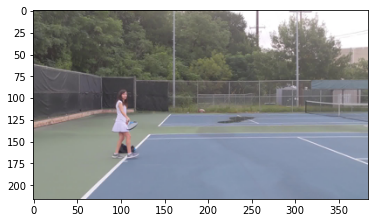

In [78]:
imgs = [makeBallImage('tmp/snapshots/' + filename, coord) for filename, coord in zip(snapshotFiles, coords) if 'jpg' in filename]
!mkdir snapshot_annotated
for idx, im in enumerate(imgs):
  plt.imshow(np.asarray(im))
  plt.savefig('snapshot_annotated/file%d.png' % idx)
  
# Create a cute video of your serves!
!ffmpeg -framerate 20 -i snapshot_annotated/file%01d.png -vcodec mpeg4 -y ball_tracking.mp4
!ffmpeg -i ball_tracking.mp4 ball_tracking.gif

The code above analyzes the snapshots and creates a gif and video you can check out in the files ball_tracking.mp4 and ball_tracking.gif respectively.

Now that the ball is tracked, you can compute it's position and then speed!

In [80]:
# For simplicity, we'll just plot the bottom left corner of the bounding box
# around the ball
coord_x = [ball[0]['x'] for frame in coords for ball in frame]
coord_y = [1 - ball[0]['y'] for frame in coords for ball in frame]
timestamps = [x/20 for x in range(len(coord_x))] # 20 frames per second

Plot the ball in space, and see how it leaves the hand and then flies across the court.

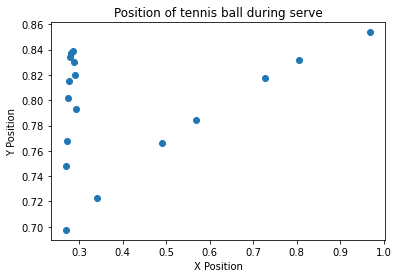

In [81]:
plt.title("Position of tennis ball during serve")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.scatter(coord_x, coord_y)
plt.savefig("serve_position_x_y.png")

To determine the speed, look at the distance the ball travels over time:

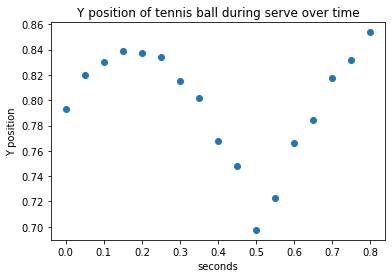

In [82]:
plt.title("Y position of tennis ball during serve over time")
plt.xlabel("seconds")
plt.ylabel("Y position")
plt.scatter(timestamps, coord_y)
plt.savefig("ball_position_over_time.png")

You can see that 0.5 to 0.7 seconds is when the ball has been hit and is traveling across the court. So, to compute the speed, let's divide distance by time!

In [83]:
# Get the first data point from 0.5 seconds
start_x = coord_x[timestamps.index(0.5)]
end_x = coord_x[-1]
start_y = coord_y[timestamps.index(0.5)]
end_y = coord_y[-1]

# Compute the Euclidean distance
distance = math.sqrt((start_x - end_x)**2 + (start_y - end_y)**2)
time = timestamps[-1] - 0.5

print(f"The speed of your serve was {distance/time}")

The speed of your serve was 2.3870913182776934
